In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In our model, we introduce a forecasting agent who attempts to exploit a possible linear relationship between a stochastic signal $\theta_t$ and asset returns $r_t$. The agent observes the entire history of returns and $\theta$, but only uses the last $n$ observations to estimate a linear model via Ordinary Least Squares (OLS). Specifically, the agent runs the regression:

$$
r_t = \beta \theta_t + \varepsilon_t
$$

If the estimated coefficient $\hat{\beta}$ is statistically significant at a chosen confidence level (e.g., 5%), the agent uses it to forecast the next-period price as:

$$
\hat{p}_{t+1} = (1 + \hat{\beta} \theta_t) \cdot p_{t-1}
$$

However, if the relationship is deemed insignificant, the agent reverts to the forecast: $\hat{p}_{t+1} = p_{t-1}$. Importantly the agent's behavior nests rational expectations. In the special case where $\beta = 0$, meaning there is no predictive relationship between $\theta$ and returns, the agent's forecast collapses to the rational expectations benchmark, where the expected future price is the current price.

The reason why the agent uses $p_{t-1}$ in its prediction is that the current price $p_t$ is an endogenous quantity which is given by 

$$ p_t = \hat{p}_{t+1} + \eta_t $$


The simulation protocol is then the following:

- We initialize the first 100 price realizations $(p_0 \dots p_{99})$
- We compute returns $(r_1 \dots r_{99})$
- We fit an OLS of returns on theta $(\theta_0 \dots \theta_{98})$
- We use theta_100 to predict r_101. This implies a resulting equilibrium price for $p_{100}$
- We redo the same but starting from $p_1$ to $p_{100}$




In [3]:
class OLSAgent:
    def __init__(self, n: int, alpha: float = 0.05):
        self.n = n  # number of past observations to use
        self.alpha = alpha  # significance level
        self.signals_detected = 0  # count of detected signals


    def predict_price(self, ret_history: np.ndarray, theta_history: np.ndarray, last_price: float) -> float:
        """
        Predict next price based on OLS of past returns on theta.
        
        Parameters:
            p_history (np.ndarray): historical prices (length T)
            theta_history (np.ndarray): historical theta values (length T)
            
        Returns:
            float: predicted price for next period
        """
        T = len(ret_history)
        if T < self.n + 1:
            raise ValueError(f"Not enough data. Require at least {self.n + 1} price points.")

        
        # Select last n observations
        X = theta_history[-self.n-1:-1]  # theta values
        y = ret_history[-self.n-1:-1]  # returns

        # Add intercept for OLS
        X_mat = np.vstack([np.ones(self.n), X]).T

        # OLS estimate: beta = (X'X)^{-1} X'y
        beta_hat = np.linalg.lstsq(X_mat, y, rcond=None)[0]

        # Compute standard errors
        residuals = y - X_mat @ beta_hat
        s2 = np.sum(residuals**2) / (self.n - 2)
        cov_beta = s2 * np.linalg.inv(X_mat.T @ X_mat)
        se_beta_1 = np.sqrt(cov_beta[1, 1])

        # t-statistic for beta_1
        t_stat = beta_hat[1] / se_beta_1
        p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), df=self.n - 2))

        theta_last = theta_history[-1]

        # Predict next price
        if p_value < self.alpha:
            self.signals_detected += 1
            return (1 + beta_hat[1] * theta_last) * last_price, beta_hat[1]
        else:
            return last_price, 0.0


In [70]:
class Market:
    def __init__(self, T: int, agent: OLSAgent, sigma_noise: float, 
                 initial_price: float = 100.0, seed: int = None):
        self.T = T
        self.agent = agent
        self.sigma_noise = sigma_noise
        self.initial_price = initial_price #p0
        self.seed = seed

        if seed is not None:
            np.random.seed(seed)
        
        # Generate AR(1) theta process
        self.theta = np.random.randn(T)
        for t in range(1, T):
            self.theta[t] += 0.9 * self.theta[t-1]

        # Initialize price and return history
        self.prices = [initial_price] # p0
        self.returns = []
        self.beta_history = []

    def run_simulation(self):
        for t in range(self.T):
            if len(self.returns) < self.agent.n + 1:
                # Not enough data yet: assume price stays constant
                predicted_price = self.prices[-1] # p_t
                beta_hat = 0.0
            else:
                predicted_price, beta_hat = self.agent.predict_price(
                    np.array(self.returns),
                    self.theta[:t],
                    self.prices[-1]
                )
            self.beta_history.append(beta_hat)
            # Add noise to predicted price
            noise = np.random.normal(0, self.sigma_noise)
            true_price = predicted_price + noise # compute p_t = p_hat + noise

            # Compute return
            last_price = self.prices[-1] # p_{t-1}
            ret = (true_price - last_price) / last_price #r_t

            # Update histories
            self.prices.append(true_price)
            self.returns.append(ret)

        return np.array(self.returns)


In [71]:
# Initialize agent and market
agent = OLSAgent(n=100, alpha=0.05)
market = Market(T=1000, agent=agent, sigma_noise=10, initial_price=100, seed=None)

# Run the simulation
return_path = market.run_simulation()

In [72]:
#check the number of signals detected, it should be almost to alpha * (T - n)
print(f"Number of signals detected: {agent.signals_detected} out of {market.T - agent.n}")
print(f"Expected (approx): {agent.alpha * (market.T - agent.n)}")


Number of signals detected: 167 out of 900
Expected (approx): 45.0


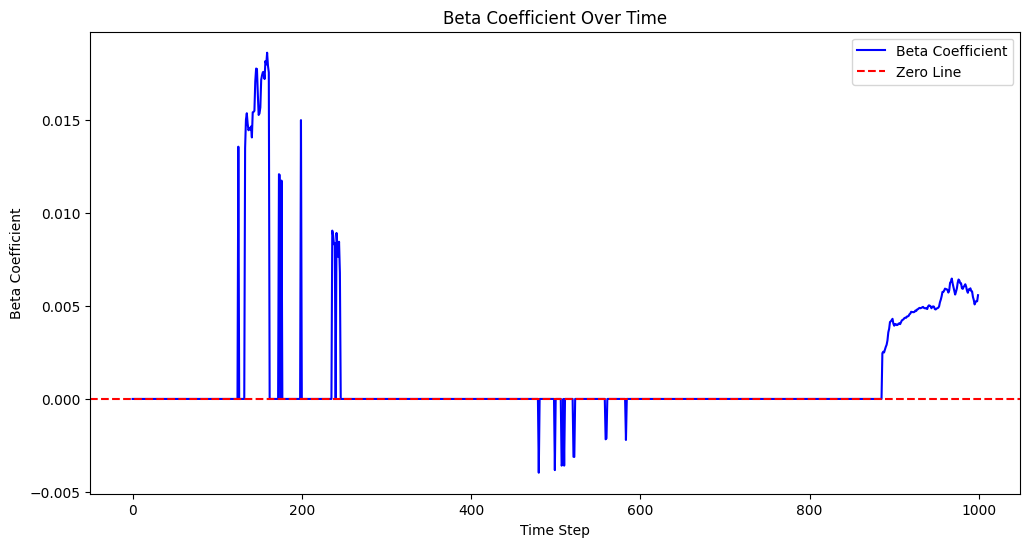

In [73]:
#visualzie the beta history
plt.figure(figsize=(12, 6))
plt.plot(market.beta_history, label='Beta Coefficient', color='blue')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')
plt.title('Beta Coefficient Over Time')
plt.xlabel('Time Step')
plt.ylabel('Beta Coefficient')
plt.legend()
plt.show()

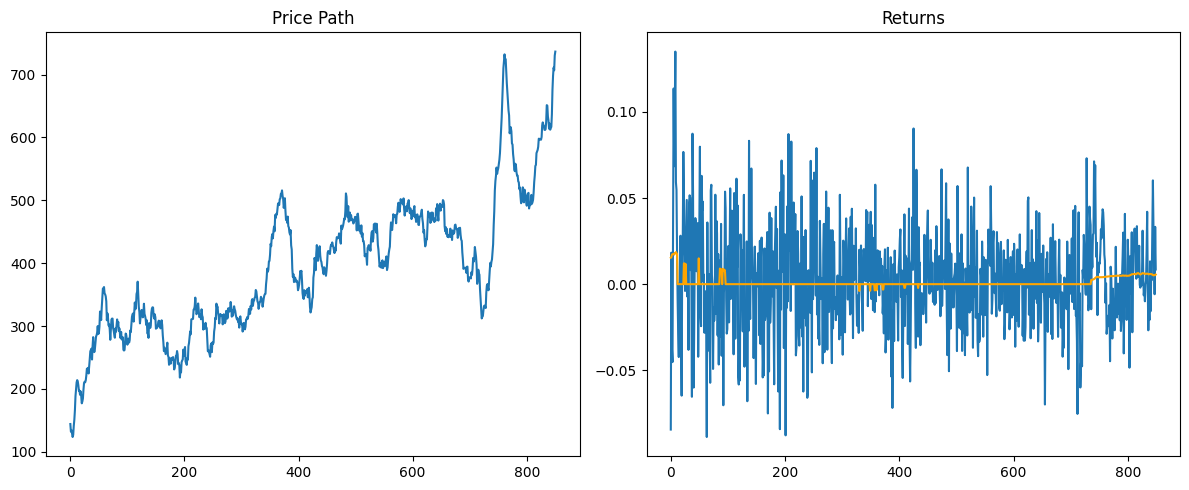

In [74]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(market.prices[150:])
plt.title("Price Path")

plt.subplot(1,2,2)
plt.plot(return_path[150:])
#add beta history
plt.plot(market.beta_history[150:], label='Beta Coefficient', color='orange')
plt.title("Returns")
plt.tight_layout()
plt.show()

In [75]:
def ex_post_theta_predictability(returns: np.ndarray, theta: np.ndarray):
    T = len(returns)
    assert len(theta) >= T, "Theta must be at least as long as returns."

    X = theta[:T]
    y = returns

    # Add intercept
    X_mat = np.vstack([np.ones(T), X]).T

    # OLS
    beta_hat = np.linalg.lstsq(X_mat, y, rcond=None)[0]
    y_hat = X_mat @ beta_hat
    residuals = y - y_hat

    # Standard error and t-stats
    s2 = np.sum(residuals**2) / (T - 2)
    cov_beta = s2 * np.linalg.inv(X_mat.T @ X_mat)
    se_beta = np.sqrt(np.diag(cov_beta))
    t_stat = beta_hat[1] / se_beta[1]
    p_value = 2 * (1 - stats.t.cdf(np.abs(t_stat), df=T - 2))

    # R-squared
    r_squared = 1 - np.sum(residuals**2) / np.sum((y - np.mean(y))**2)

    print("Ex-post regression of returns on theta:")
    print(f"  β̂ = {beta_hat[1]:.4f}, t = {t_stat:.2f}, p = {p_value:.4f}, R² = {r_squared:.4f}")
    
    return {
        "beta": beta_hat[1],
        "t_stat": t_stat,
        "p_value": p_value,
        "r_squared": r_squared
    }


In [76]:
# After running the market
results = ex_post_theta_predictability(
    returns=np.array(market.returns)[100:],
    theta=market.theta[100:]
)

Ex-post regression of returns on theta:
  β̂ = 0.0016, t = 2.27, p = 0.0231, R² = 0.0057


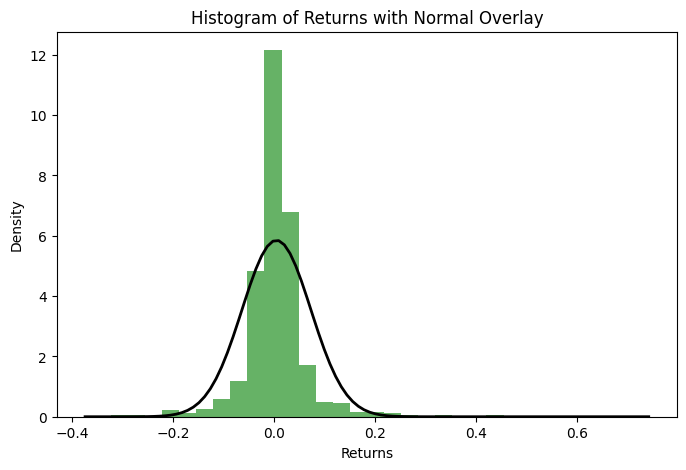

In [77]:
# Plot an histogram of returns distribution
plt.figure(figsize=(8, 5))
plt.hist(market.returns, bins=30, density=True, alpha=0.6, color='g')
plt.title("Histogram of Returns")
plt.xlabel("Returns")
#overlay a normal distribution
mu, std = np.mean(market.returns), np.std(market.returns)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.title("Histogram of Returns with Normal Overlay")
plt.xlabel("Returns")
plt.ylabel("Density")
plt.show()